#### 作业五

1. 将dropout和ReLU应用于LeNet，效果有提升吗？再试试预处理会怎么样？

解：
实验表明，在LeNet-5架构中未经调整地直接引入dropout层和ReLU激活函数，并维持原始0.9的学习率时，模型的训练过程无法稳定收敛。通过将学习率适当调低后，模型的训练效果得到了明显改善。值得注意的是，当对输入数据进行归一化处理后，模型的性能表现获得了进一步提升
实现代码如下所示:

loss 0.360, train acc 0.872, test acc 0.875
34100.7 examples/sec on cuda:0


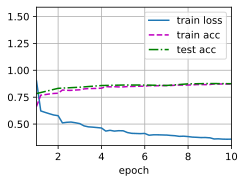

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=32)
# 
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 6 * 6, 120), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(84, 10))

lr, num_epochs = 0.3, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

2. 比较LeNet在使用和不使用BN情况下的不同的学习率对测试准确度的影响。

带BN的LeNet会在每个卷积层和全连接层后添加批量归一化层，而不带BN的LeNet则会移除所有批量归一化层，激活函数直接跟在卷积或全连接层后。
以下将测试多个学习率：[0.1, 0.03, 0.01, 0.003, 0.001]，覆盖较大到较小的范围。
如果符合预测的话，使用BN的模型会在高学习率（如0.1）下表现稳定，测试准确度较高；低学习率下收敛稍慢，但最终准确度仍然较好。
而不使用BN的模型会在高学习率下容易发散（如0.1），测试准确度显著下降；低学习率（如0.001）下收敛缓慢，准确度较低。
然后对于BN的鲁棒性，BN允许使用更大的学习率，加速训练并提升模型性能。
以下是测试的代码:

lr=1e-01: BN=0.878, NoBN=0.100
lr=3e-02: BN=0.900, NoBN=0.860
lr=1e-02: BN=0.898, NoBN=0.881
lr=3e-03: BN=0.900, NoBN=0.886
lr=1e-03: BN=0.890, NoBN=0.885


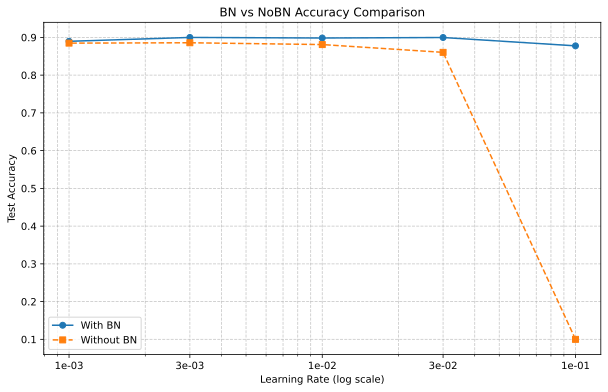

In [17]:
import torch
from torch import nn
from torchvision import transforms
from d2l import torch as d2l
import matplotlib.pyplot as plt

# 定义带BN的LeNet
def lenet_bn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.ReLU(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.ReLU(),
        nn.AvgPool2d(2, 2), nn.Flatten(),
        nn.Linear(256, 120), nn.BatchNorm1d(120), nn.ReLU(),
        nn.Linear(120, 84), nn.BatchNorm1d(84), nn.ReLU(),
        nn.Linear(84, 10))
    # Kaiming初始化
    def init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    model.apply(init_weights)
    return model

# 定义不带BN的LeNet（保持其他结构相同）
def lenet_no_bn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5), nn.ReLU(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.AvgPool2d(2, 2), nn.Flatten(),
        nn.Linear(256, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))
    # 相同初始化
    def init_weights(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    model.apply(init_weights)
    return model

# 数据标准化（对不带BN的模型更重要）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 统一训练函数
def train_model(model, lr):
    device = d2l.try_gpu()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(10):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric.add(loss * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
                
        train_loss = metric[0]/metric[2]
        train_acc = metric[1]/metric[2]
        
    test_acc = d2l.evaluate_accuracy_gpu(model, test_iter)
    return test_acc

# 测试不同学习率
lr_list = [0.1, 0.03, 0.01, 0.003, 0.001]
bn_acc = []
no_bn_acc = []

for lr in lr_list:
    # 训练带BN模型
    model_bn = lenet_bn()
    acc_bn = train_model(model_bn, lr)
    bn_acc.append(acc_bn)
    
    # 训练不带BN模型
    model_no_bn = lenet_no_bn()
    acc_no_bn = train_model(model_no_bn, lr)
    no_bn_acc.append(acc_no_bn)
    
    print(f'lr={lr:.0e}: BN={acc_bn:.3f}, NoBN={acc_no_bn:.3f}')

# 可视化对比
plt.figure(figsize=(10,6))
plt.semilogx(lr_list, bn_acc, 'o-', label='With BN')
plt.semilogx(lr_list, no_bn_acc, 's--', label='Without BN')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Test Accuracy')
plt.xticks(lr_list, [f'{lr:.0e}' for lr in lr_list])
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.title('BN vs NoBN Accuracy Comparison')
plt.show()

3. 借助工具(如torchsummary)将AlexNet、VGG和NiN的模型参数大小与GoogLeNet进行比较。后两个网络架构是如何显著减少模型参数大小的？

解：
考虑偏置的情况下：
卷积层参数量 = $c_i c_o k^2 + c_o$
池化层参数量 = 0
全连接层参数量 =$c_i * c_o +  c_o$
设输入图像尺寸均为224×224，各模型参数大小如下：
$$
\begin{array}{|c|c|c|c|c|}
\hline
{Model} & {AlexNet} & {VGG} & {NiN} & {GoogLeNet} \\
\hline
{Params(MB)} & {44.62} & {41.10} & {1.92} & {5.71} \\
\hline
\end{array}
$$
AlexNet和VGG都是使用连续的较大卷积核（3×3或5×5）提取特征，大于1的平方计算与较大的通道数相乘，会产生较多的参数；此外，卷积层之后，二者都使用大尺寸的全连接层进一步处理特征，从而产生大量的参数。
而NiN和GoogLeNet则使用1×1卷积层替代全连接层，或在进行较大卷积核计算前先使用1×1卷积层降维（减小），从而减少参数量。
可以通过以下代码进行查看:

In [18]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.nn import functional as F

# 定义AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 定义VGG16
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 定义NiN
class NiN(nn.Module):
    def __init__(self, num_classes=1000):
        super(NiN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(160, 96, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.5),
            nn.Conv2d(96, 192, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.5),
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, num_classes, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        return self.features(x)

# 定义GoogLeNet（使用简化版）
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4):
        super(Inception, self).__init__()
        self.p1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2 = nn.Sequential(
            nn.Conv2d(in_channels, c2[0], kernel_size=1),
            nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        )
        self.p3 = nn.Sequential(
            nn.Conv2d(in_channels, c3[0], kernel_size=1),
            nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        )
        self.p4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, c4, kernel_size=1)
        )

    def forward(self, x):
        p1 = F.relu(self.p1(x))
        p2 = F.relu(self.p2(x))
        p3 = F.relu(self.p3(x))
        p4 = F.relu(self.p4(x))
        return torch.cat((p1, p2, p3, p4), dim=1)

class GoogleNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogleNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Inception(192, 64, (96, 128), (16, 32), 32),
            Inception(256, 128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Inception(480, 192, (96, 208), (16, 48), 64),
            Inception(512, 160, (112, 224), (24, 64), 64),
            Inception(512, 128, (128, 256), (24, 64), 64),
            Inception(512, 112, (144, 288), (32, 64), 64),
            Inception(528, 256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Inception(832, 256, (160, 320), (32, 128), 128),
            Inception(832, 384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 统计参数量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = (3, 224, 224)  # 假设输入为224x224的RGB图像

alexnet = AlexNet().to(device)
vgg = VGG16().to(device)
nin = NiN().to(device)
googlenet = GoogleNet().to(device)

print("AlexNet参数量：")
summary(alexnet, input_shape)

print("\nVGG16参数量：")
summary(vgg, input_shape)

print("\nNiN参数量：")
summary(nin, input_shape)

print("\nGoogLeNet参数量：")
summary(googlenet, input_shape)

AlexNet参数量：
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14       

4. 利用RseNet作为`作业四第2题`任务模型的的Backbone(骨干网络)，观察准确度是否有所提升。

使用RseNet作为Backbone后，具体的代码如下所示:

使用设备: cuda


Epoch 1/20: 100%|██████████| 121/121 [00:27<00:00,  4.41batch/s, loss=1.6344, acc=74.33%]


Epoch 1/20
Train Loss: 1.0861 | Acc: 74.33%
Val Loss: 0.6003 | Acc: 84.29%
LR: 1.00e-04


Epoch 2/20: 100%|██████████| 121/121 [00:23<00:00,  5.26batch/s, loss=1.2005, acc=88.66%]


Epoch 2/20
Train Loss: 0.5210 | Acc: 88.66%
Val Loss: 0.5414 | Acc: 85.57%
LR: 1.00e-04


Epoch 3/20: 100%|██████████| 121/121 [00:22<00:00,  5.34batch/s, loss=1.1818, acc=92.90%]


Epoch 3/20
Train Loss: 0.3539 | Acc: 92.90%
Val Loss: 0.4326 | Acc: 86.84%
LR: 1.00e-04


Epoch 4/20: 100%|██████████| 121/121 [00:22<00:00,  5.32batch/s, loss=0.1612, acc=93.91%]


Epoch 4/20
Train Loss: 0.2756 | Acc: 93.91%
Val Loss: 0.4211 | Acc: 87.02%
LR: 1.00e-04


Epoch 5/20: 100%|██████████| 121/121 [00:22<00:00,  5.35batch/s, loss=0.1431, acc=96.93%]


Epoch 5/20
Train Loss: 0.1762 | Acc: 96.93%
Val Loss: 0.4344 | Acc: 87.75%
LR: 1.00e-04


Epoch 6/20: 100%|██████████| 121/121 [00:22<00:00,  5.45batch/s, loss=1.2808, acc=97.37%]


Epoch 6/20
Train Loss: 0.1485 | Acc: 97.37%
Val Loss: 0.4166 | Acc: 87.39%
LR: 1.00e-04


Epoch 7/20: 100%|██████████| 121/121 [00:21<00:00,  5.54batch/s, loss=0.3069, acc=97.82%]


Epoch 7/20
Train Loss: 0.1323 | Acc: 97.82%
Val Loss: 0.4121 | Acc: 87.81%
LR: 1.00e-04


Epoch 8/20: 100%|██████████| 121/121 [00:21<00:00,  5.52batch/s, loss=0.0865, acc=97.97%]


Epoch 8/20
Train Loss: 0.1058 | Acc: 97.97%
Val Loss: 0.4330 | Acc: 87.27%
LR: 1.00e-04


Epoch 9/20: 100%|██████████| 121/121 [00:22<00:00,  5.49batch/s, loss=1.4554, acc=98.78%]


Epoch 9/20
Train Loss: 0.0849 | Acc: 98.78%
Val Loss: 0.4229 | Acc: 87.75%
LR: 1.00e-04


Epoch 10/20: 100%|██████████| 121/121 [00:24<00:00,  4.93batch/s, loss=0.0818, acc=98.15%]


Epoch 10/20
Train Loss: 0.0933 | Acc: 98.15%
Val Loss: 0.4288 | Acc: 86.84%
LR: 1.00e-04


Epoch 11/20: 100%|██████████| 121/121 [00:21<00:00,  5.53batch/s, loss=0.3100, acc=98.96%]


Epoch 11/20
Train Loss: 0.0688 | Acc: 98.96%
Val Loss: 0.4266 | Acc: 87.69%
LR: 1.00e-05


Epoch 12/20: 100%|██████████| 121/121 [00:22<00:00,  5.49batch/s, loss=0.0714, acc=99.38%]


Epoch 12/20
Train Loss: 0.0466 | Acc: 99.38%
Val Loss: 0.3997 | Acc: 88.84%
LR: 1.00e-05


Epoch 13/20: 100%|██████████| 121/121 [00:21<00:00,  5.54batch/s, loss=0.4127, acc=99.58%]


Epoch 13/20
Train Loss: 0.0403 | Acc: 99.58%
Val Loss: 0.3925 | Acc: 89.02%
LR: 1.00e-05


Epoch 14/20: 100%|██████████| 121/121 [00:22<00:00,  5.27batch/s, loss=0.1558, acc=99.66%]


Epoch 14/20
Train Loss: 0.0367 | Acc: 99.66%
Val Loss: 0.3860 | Acc: 88.72%
LR: 1.00e-05


Epoch 15/20: 100%|██████████| 121/121 [00:22<00:00,  5.47batch/s, loss=0.0670, acc=99.77%]


Epoch 15/20
Train Loss: 0.0323 | Acc: 99.77%
Val Loss: 0.3867 | Acc: 88.48%
LR: 1.00e-05


Epoch 16/20: 100%|██████████| 121/121 [00:21<00:00,  5.51batch/s, loss=0.3408, acc=99.79%]


Epoch 16/20
Train Loss: 0.0331 | Acc: 99.79%
Val Loss: 0.3756 | Acc: 89.27%
LR: 1.00e-05


Epoch 17/20: 100%|██████████| 121/121 [00:21<00:00,  5.50batch/s, loss=0.0205, acc=99.77%]


Epoch 17/20
Train Loss: 0.0286 | Acc: 99.77%
Val Loss: 0.3717 | Acc: 89.51%
LR: 1.00e-05


Epoch 18/20: 100%|██████████| 121/121 [00:23<00:00,  5.05batch/s, loss=0.4472, acc=99.79%]


Epoch 18/20
Train Loss: 0.0307 | Acc: 99.79%
Val Loss: 0.3681 | Acc: 89.69%
LR: 1.00e-05


Epoch 19/20: 100%|██████████| 121/121 [00:22<00:00,  5.33batch/s, loss=0.0450, acc=99.92%]


Epoch 19/20
Train Loss: 0.0240 | Acc: 99.92%
Val Loss: 0.3788 | Acc: 89.08%
LR: 1.00e-05


Epoch 20/20: 100%|██████████| 121/121 [00:22<00:00,  5.43batch/s, loss=0.1744, acc=99.79%]


Epoch 20/20
Train Loss: 0.0271 | Acc: 99.79%
Val Loss: 0.3804 | Acc: 89.39%
LR: 1.00e-05


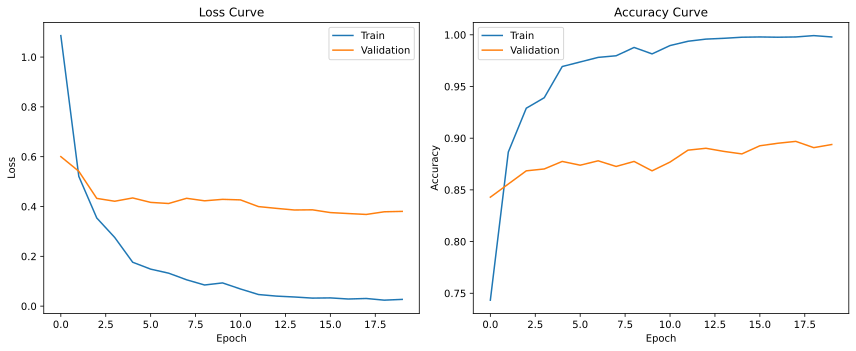

模型已保存为 final_model.pth


In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm  # 添加进度条支持

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 超参数配置
CONFIG = {
    "data_dir": r"D:\Code\temppy\zuoye\深度学习\4\agriculture_pests",  # 数据路径
    "image_size": 224,          # 输入尺寸
    "batch_size": 32,           # 批大小
    "num_epochs": 20,           # 训练轮次
    "lr": 1e-4,                 # 初始学习率
    "num_classes": 12           # 分类类别数
}

# 类别名称映射
class_names = ['ants', 'bees', 'beetles', 'caterpillars', 'earthworms', 'earwigs',
               'grasshoppers', 'moths', 'slugs', 'snails', 'wasps', 'weevils']

# 增强型混合模型
class EnhancedHybridCNN(nn.Module):
    def __init__(self, num_classes=CONFIG["num_classes"]):
        super().__init__()
        # 加载预训练ResNet18
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # 修正后的主干网络
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # 正确闭合
        
        # 修正后的自定义头部
        self.custom_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )  # 正确闭合

    def forward(self, x):
        x = self.backbone(x)
        return self.custom_head(x)

# 数据增强与预处理
def get_transforms():
    return transforms.Compose([
        transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# 数据加载与划分
def prepare_data():
    # 检查数据路径
    if not os.path.exists(CONFIG["data_dir"]):
        raise FileNotFoundError(f"数据目录 {CONFIG['data_dir']} 不存在！")

    # 创建完整数据集
    full_dataset = datasets.ImageFolder(
        root=CONFIG["data_dir"],
        transform=get_transforms()
    )
    
    # 固定随机种子保证可重复性
    torch.manual_seed(76)
    # 划分数据集
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(
        full_dataset, [train_size, test_size],
        generator=torch.Generator().manual_seed(76)
    )
    
    # 创建数据加载器
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG["batch_size"],
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, test_loader

# 训练函数
def train_model(model, train_loader, test_loader):
    model = model.to(device)
    
    # 损失函数与优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    # 训练指标记录
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_acc = 0.0
    
    for epoch in range(CONFIG["num_epochs"]):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}") as pbar:
            for images, labels in pbar:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                # 前向传播
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # 反向传播
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # 统计指标
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{correct/total*100:.2f}%"
                })
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        # 记录指标
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_loss = val_loss / len(test_loader)
        val_acc = val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
        
        # 打印日志
        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
        print(f"LR: {optimizer.param_groups[0]['lr']:.2e}\n")
    
    return history

# 可视化函数
def visualize_results(history):
    plt.figure(figsize=(12, 5))
    
    # 损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation') 
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# 主程序
if __name__ == "__main__":
    # 准备数据
    train_loader, test_loader = prepare_data()
    
    # 初始化模型
    model = EnhancedHybridCNN()
    
    # 训练模型
    history = train_model(model, train_loader, test_loader)
    
    # 可视化结果
    visualize_results(history)
    
    # 保存最终模型
    torch.save(model.state_dict(), "final_model.pth")
    print("模型已保存为 final_model.pth")

可以看到，使用了RseNet作为Backbone后，准确率有较大的提升